In [4]:
from datetime import datetime
start_real = datetime.now() # 全体の処理時間の計測を開始する

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

#### データの読み込み

In [5]:
train = pd.read_csv("/kaggle/input/mercari-dataset/train.tsv", delimiter='\t')
test = pd.read_csv("/kaggle/input/mercari-dataset/test.tsv", delimiter='\t')

#### データの全体像
train：1,482,535個のユーザーが投稿した商品

test：693,359行で「価格（Price）」の項目がテストデータは含まれていないため、列数は「7」となっている 

* train_id / test _id – ユーザー投稿のID
* name – 投稿のタイトル。タイトルに価格に関する情報がある場合（例：$20）はメルカリが事前に削除をして[rm]と置き換えている。
* item_condition_id – ユーザーが指定した商品の状態(1~5,大きい方が状態が良い)
* category_name – 投稿カテゴリー
* brand_name – ブランドの名前
* price – 訓練データのみ。実際に売られた価格。米ドル表示。今回のチャレンジの予測ターゲットとなる。
* shipping – 送料のフラグ。「1」は販売者負担。「0」は購入者負担。
* item_description – ユーザーが投稿した商品説明の全文。タイトルと同様に価格情報がある場合は[rm]と置き換えられている。

In [6]:
print(train.shape)
print(train.info())
display(train.head())

(1482535, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [7]:
print(test.shape)
print(test.info())
display(test.head())

(693359, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693359 entries, 0 to 693358
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   test_id            693359 non-null  int64 
 1   name               693359 non-null  object
 2   item_condition_id  693359 non-null  int64 
 3   category_name      690301 non-null  object
 4   brand_name         397834 non-null  object
 5   shipping           693359 non-null  int64 
 6   item_description   693359 non-null  object
dtypes: int64(3), object(4)
memory usage: 37.0+ MB
None


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


#### ----------------- price -----------------

#### 3ドル未満のレコードを削除

In [8]:
train = train.drop(train[(train.price < 3.0)].index)
print(train.shape)
print(train["price"].min()) #priceの最小値
print(train["price"].max()) #priceの最大値

(1481661, 8)
3.0
2009.0


1,482,535→1,481,661点となり、874の商品が削除された

#### priceを対数変換して正規化

In [9]:
# 訓練データの'price'を対数変換する
train['price'] = np.log1p(train['price'])

#### ----------------- category_name -----------------

#### general_category, sub_category1, sub_category2 に3等分する

In [10]:
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label") #categoryがない場合はNo Labelを返す

train['general_cat'], train['sub_cat1'], train['sub_cat2'] = zip(*train['category_name'].apply(lambda x: split_cat(x))) #zip(*df)で転置
display(train.head())
test['general_cat'], test['sub_cat1'], test['sub_cat2'] = zip(*test['category_name'].apply(lambda x: split_cat(x)))
display(test.head())

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,2.397895,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,3.583519,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,3.806662,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,general_cat,sub_cat1,sub_cat2
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7,Women,Jewelry,Rings
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,Handbag
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,Cardigan
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...,Other,Books,Religion & Spirituality


#### train,testを縦方向に結合し、まとめて前処理できるようにする
> 変更点  
> trainデータフレームとtestデータフレームをpd.concat([train, test])で結合すると、1列目の列名が異なるため、test_id列が末尾にNaNとして挿入されてしまう。  
> これを避けるために、一度train_idとtest_idをidに変更し、列名を統一してから結合する。

In [11]:
# 列名をidに変更
train.rename(columns={'train_id': 'id'}, inplace=True) # <---
test.rename(columns={'test_id': 'id'}, inplace=True) # <---

# データフレームを結合
train_test_combine = pd.concat([train,test]) #axis=0で行、axis=1で列に結合 デフォルトはaxis=0
print(train_test_combine.shape)
train_test_combine.head()

(2175020, 11)


,id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,2.397895,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,3.583519,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,3.806662,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


train：1,482,535個の商品  
test：693,359個の商品  
train_test_combine：2,175,894個の商品

#### ----------------- brand_name -----------------

#### 欠損値処理
1. ブランド名の欠損値(NaN)を"missing"に置き換える
2. このままだと欠損値であることに変わりないので、"name(商品名)"が、ブランド名のリストに含まれる場合、ブランド名の"missing"を"name(商品名)"に書き換える

これにより、ブランド名(brand_name)が記載されていない商品でも、商品名(name)からブランド名を取得し、代入することができる

In [12]:
#brand_nameの重複なしのリストを作成
brand_name_list = set(train_test_combine["brand_name"].values) #set()で重複を削除

# 'brand_name'の欠損値NaNを'missing'に置き換える
train['brand_name'].fillna(value='missing', inplace=True)
test['brand_name'].fillna(value='missing', inplace=True)

# 訓練データの'brand_name'が'missing'に一致するレコード数を取得
train_premissing = len(train.loc[train['brand_name'] == 'missing'])
# テストデータの'brand_name'が'missing'に一致するレコード数を取得
test_premissing = len(test.loc[test['brand_name'] == 'missing'])

train_premissing, test_premissing #欠損値の数

(632336, 295525)

brand_name(trainデータ): 63万点のうち、13.7万点がブランド名を表すデータに書き換えられた  
brand_name(testデータ): 29万点のうち、6.4万点がブランド名を表すデータに書き換えられた

In [13]:
%%time
def brandfinder(line):
    brand = line[0] # 第1要素はブランド名
    name = line[1]  # 第2要素は商品名
    namesplit = name.split(' ') # 商品名をスペースで切り分ける
    
    if brand == 'missing':  # ブランド名が'missing'の場合
        for x in namesplit: # 商品名から切り分けた単語を取り出す
            if x in brand_name_list: # 単語がブランドリストに存在すればブランド名を返す              
                return name # 単語がブランドリストに一致したら商品名を返す
    if name in brand_name_list:  # 商品名がブランドリストに存在すれば商品名を返す
        return name
    
    return brand            # どれにも一致しなければブランド名を返す

# ブランド名の付替えを実施
train['brand_name'] = train[['brand_name','name']].apply(brandfinder, axis = 1) #axis=1で行方向
test['brand_name'] = test[['brand_name','name']].apply(brandfinder, axis = 1)

# 書き換えられた'missing'の数を取得
train_found = train_premissing-len(train.loc[train['brand_name'] == 'missing'])
test_found = test_premissing-len(test.loc[test['brand_name'] == 'missing'])

print(train_premissing) # 書き換える前の'missing'の数
print(train_found)      # 書き換えられた'missing'の数
print(test_premissing)  # 書き換える前の'missing'の数
print(test_found)       # 書き換えられた'missing'の数

632336
137342
295525
64154
CPU times: user 1min 12s, sys: 287 ms, total: 1min 12s
Wall time: 1min 12s


In [14]:
train.head()

,id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,MLB Cincinnati Reds T Shirt Size XL,2.397895,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,3.583519,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,3.806662,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


たとえば一行目の "brand_name" は missing → MLB Cincinnati となり、missingが"name(商品名)" に書き換えられたことがわかる

#### ----------------- エンコーディング (文字列→数値データ) -----------------

- name
- category_name
- brand_name
- item_description

の欠損値(NaN)を"missing"で埋める

In [15]:
#fillna()で欠損値を埋める
train_test_combine['name'].fillna(value='missing', inplace=True)
train_test_combine['category_name'].fillna(value='missing', inplace=True)
train_test_combine['general_cat'].fillna(value='missing', inplace=True)
train_test_combine['sub_cat1'].fillna(value='missing', inplace=True)
train_test_combine['sub_cat2'].fillna(value='missing', inplace=True)
train_test_combine['brand_name'].fillna(value='missing', inplace=True)
train_test_combine['item_description'].fillna(value='missing', inplace=True)

カテゴリカルデータ（離散的なカテゴリを持つデータ）である  
- category_name
- general_cat
- sub_cat1
- sub_cat2
- brand_name

を数値に変換

In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

#カテゴリ変数を数値に変換
# train_test_combine['name'] = le.fit_transform(train_test_combine['name'])
train_test_combine['category_name'] = le.fit_transform(train_test_combine['category_name'])
train_test_combine['general_cat'] = le.fit_transform(train_test_combine['general_cat'])
train_test_combine['sub_cat1'] = le.fit_transform(train_test_combine['sub_cat1'])
train_test_combine['sub_cat2'] = le.fit_transform(train_test_combine['sub_cat2'])
train_test_combine['brand_name'] = le.fit_transform(train_test_combine['brand_name'])

display(train_test_combine.head())

,id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5263,2.397895,1,No description yet,5,103,774
1,1,Razer BlackWidow Chroma Keyboard,3,86,3887,3.970292,0,This keyboard is in great condition and works ...,1,30,215
2,2,AVA-VIV Blouse,1,1277,4586,2.397895,1,Adorable top with a hint of lace and a key hol...,10,104,97
3,3,Leather Horse Statues,1,503,5263,3.583519,1,New with tags. Leather horses. Retail for [rm]...,3,55,410
4,4,24K GOLD plated rose,1,1204,5263,3.806662,0,Complete with certificate of authenticity,10,58,542


#### name, item_descriptionをエンコード(自然言語処理)
name, item_descriptionは複数の単語で構成されるので、単純なエンコード(数値変換)ではなく、KerasのTokenizerクラスを使ってエンコード

Tokenizerとは

* 英文のテキストデータをトークン(最小単位)に分解する
* 各トークンに通し番号(インデックス)を割り振ることで実数ベクトルに変換する

分かりやすいzenn記事：https://zenn.dev/robes/articles/b6708032855a9c

In [17]:
%%time
from tensorflow.keras.preprocessing.text import Tokenizer

print("Transforming text data to sequences...")
raw_text = np.hstack(
    [train_test_combine.item_description.str.lower(), # 説明文
     train_test_combine.name.str.lower()]           # 商品名
)
print('sequences shape', raw_text.shape)

# 説明文、商品名、カテゴリ名を連結した配列でTokenizerを作る
print("   Fitting tokenizer...")
tok_raw = Tokenizer()
tok_raw.fit_on_texts(raw_text)

# Tokenizerで説明文、商品名をそれぞれラベルエンコードする
print("   Transforming text to sequences...")
train_test_combine['seq_item_description'] = tok_raw.texts_to_sequences(train_test_combine.item_description.str.lower())
train_test_combine['seq_name'] = tok_raw.texts_to_sequences(train_test_combine.name.str.lower())

del tok_raw #delは変数を削除する

print(train_test_combine.seq_item_description.head())
print(train_test_combine.seq_name.head())

Transforming text data to sequences...
sequences shape (4350040,)
   Fitting tokenizer...
   Transforming text to sequences...
0                                         [12, 68, 79]
1    [29, 2666, 10, 7, 38, 17, 1, 206, 51, 19, 1099...
2    [597, 60, 9, 4, 5351, 11, 192, 1, 4, 900, 1299...
3    [5, 9, 61, 178, 6621, 229, 3, 21, 166, 1086, 2...
4                             [801, 9, 7022, 11, 2013]
Name: seq_item_description, dtype: object
0    [3882, 8986, 6977, 208, 84, 6, 155]
1            [11402, 27914, 17350, 2666]
2                     [7811, 10858, 666]
3                     [178, 2603, 14008]
4                 [4962, 103, 1032, 280]
Name: seq_name, dtype: object
CPU times: user 3min 31s, sys: 2.93 s, total: 3min 34s
Wall time: 3min 39s


#### 0でパディング(埋める)して配列の長さを揃える

自然言語処理の学習における入力データは固定長化する必要がある

参考サイト；https://moneyforward-dev.jp/entry/2021/10/05/transformers-tokenizer/

In [19]:
%%time
from keras.preprocessing.sequence import pad_sequences

padded_item_description = pad_sequences(train_test_combine.seq_item_description, maxlen=80) # 商品説明
padded_name = pad_sequences(train_test_combine.seq_name, maxlen=10) # 商品名

print(padded_item_description,'\n')
print(padded_name)

[[    0     0     0 ...    12    68    79]
 [    0     0     0 ...    14    49   996]
 [    0     0     0 ...   175     7    59]
 ...
 [    0     0     0 ...    20 63502    88]
 [    0     0     0 ...     4   369    71]
 [    0     0     0 ...     4   593   635]] 

[[    0     0     0 ...    84     6   155]
 [    0     0     0 ... 27914 17350  2666]
 [    0     0     0 ...  7811 10858   666]
 ...
 [    0     0     0 ...   401  1559    88]
 [    0     0     0 ...   325   281  2230]
 [    0     0     0 ...   892   725    69]]
CPU times: user 14.4 s, sys: 173 ms, total: 14.6 s
Wall time: 14.6 s


In [20]:
# 各要素ごとに分割して新しい列を作成
for i in range(80):
    train_test_combine[f'seq_item_description_{i}'] = padded_item_description[:, i]

for i in range(10):
    train_test_combine[f'seq_name_{i}'] = padded_name[:, i]

In [21]:
train_test_combine.head()

,id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,...,seq_name_0,seq_name_1,seq_name_2,seq_name_3,seq_name_4,seq_name_5,seq_name_6,seq_name_7,seq_name_8,seq_name_9
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5263,2.397895,1,No description yet,5,103,...,0,0,0,3882,8986,6977,208,84,6,155
1,1,Razer BlackWidow Chroma Keyboard,3,86,3887,3.970292,0,This keyboard is in great condition and works ...,1,30,...,0,0,0,0,0,0,11402,27914,17350,2666
2,2,AVA-VIV Blouse,1,1277,4586,2.397895,1,Adorable top with a hint of lace and a key hol...,10,104,...,0,0,0,0,0,0,0,7811,10858,666
3,3,Leather Horse Statues,1,503,5263,3.583519,1,New with tags. Leather horses. Retail for [rm]...,3,55,...,0,0,0,0,0,0,0,178,2603,14008
4,4,24K GOLD plated rose,1,1204,5263,3.806662,0,Complete with certificate of authenticity,10,58,...,0,0,0,0,0,0,4962,103,1032,280


#### name, item_descriptionの単語数をカウントした列を追加

> 変更点  
> - **正規表現によるクリーニングの追加**: テキストから句読点や数字、改行、タブ文字を削除し、クリーンなテキストを生成することで、単語数のカウントをより正確にする。  
> - **ストップワードの除去の追加**: 一般的な英語のストップワード（情報検索の際に無視される単語）を除去し、実際の情報量に基づいた単語数をカウントする。また、3文字未満の単語も除外することで、より有意義な単語のみを対象とする。

In [22]:
%%time
import re # <---
import string # <---
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS # <---

def wordCount(text):
    """
    Parameters:
      text(str): 商品名、商品の説明文
    """
    try:
        if text == 'No description yet':
            return 1  # <--- 商品名や説明が'No description yet'の場合は1を返す
        else:
            text = text.lower()  # <--- すべて小文字にする
            # <--- 正規表現を使用して句読点や数字を削除
            regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
            text = regex.sub(" ", text)
            # <--- ストップワードを除去
            words = [w for w in text.split() if w and w not in ENGLISH_STOP_WORDS and len(w) >= 3]
            return len(words)  # 単語の数を返す
    except: 
        return 0


# 'name'の各フィールドの単語数を'name_len'に登録
train_test_combine['name_len'] = train_test_combine['name'].apply(lambda x: wordCount(x))
# 'item_description'の各フィールドの単語数を'desc_len'に登録
train_test_combine['desc_len'] = train_test_combine['item_description'].apply(lambda x: wordCount(x))

CPU times: user 49.1 s, sys: 72.2 ms, total: 49.2 s
Wall time: 49.3 s


In [23]:
print(train_test_combine.shape)
print(train_test_combine.info())
display(train_test_combine.head())

(2175020, 105)
<class 'pandas.core.frame.DataFrame'>
Index: 2175020 entries, 0 to 693358
Columns: 105 entries, id to desc_len
dtypes: float64(1), int32(90), int64(10), object(4)
memory usage: 1012.2+ MB
None


,id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,...,seq_name_2,seq_name_3,seq_name_4,seq_name_5,seq_name_6,seq_name_7,seq_name_8,seq_name_9,name_len,desc_len
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5263,2.397895,1,No description yet,5,103,...,0,3882,8986,6977,208,84,6,155,5,1
1,1,Razer BlackWidow Chroma Keyboard,3,86,3887,3.970292,0,This keyboard is in great condition and works ...,1,30,...,0,0,0,0,11402,27914,17350,2666,4,16
2,2,AVA-VIV Blouse,1,1277,4586,2.397895,1,Adorable top with a hint of lace and a key hol...,10,104,...,0,0,0,0,0,7811,10858,666,3,9
3,3,Leather Horse Statues,1,503,5263,3.583519,1,New with tags. Leather horses. Retail for [rm]...,3,55,...,0,0,0,0,0,178,2603,14008,3,17
4,4,24K GOLD plated rose,1,1204,5263,3.806662,0,Complete with certificate of authenticity,10,58,...,0,0,0,0,4962,103,1032,280,3,3


In [27]:
# 欠損値が残っていないか確認
# print(train_test_combine.isnull().sum())
missing_data = train_test_combine.isnull().sum()
missing_data = missing_data[missing_data > 0]
print(missing_data)

price    693359
dtype: int64


In [28]:
print(train_test_combine.shape)
print(train_test_combine.info())
display(train_test_combine.head())

(2175020, 105)
<class 'pandas.core.frame.DataFrame'>
Index: 2175020 entries, 0 to 693358
Columns: 105 entries, id to desc_len
dtypes: float64(1), int32(90), int64(10), object(4)
memory usage: 1012.2+ MB
None


,id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,...,seq_name_2,seq_name_3,seq_name_4,seq_name_5,seq_name_6,seq_name_7,seq_name_8,seq_name_9,name_len,desc_len
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5263,2.397895,1,No description yet,5,103,...,0,3882,8986,6977,208,84,6,155,5,1
1,1,Razer BlackWidow Chroma Keyboard,3,86,3887,3.970292,0,This keyboard is in great condition and works ...,1,30,...,0,0,0,0,11402,27914,17350,2666,4,16
2,2,AVA-VIV Blouse,1,1277,4586,2.397895,1,Adorable top with a hint of lace and a key hol...,10,104,...,0,0,0,0,0,7811,10858,666,3,9
3,3,Leather Horse Statues,1,503,5263,3.583519,1,New with tags. Leather horses. Retail for [rm]...,3,55,...,0,0,0,0,0,178,2603,14008,3,17
4,4,24K GOLD plated rose,1,1204,5263,3.806662,0,Complete with certificate of authenticity,10,58,...,0,0,0,0,4962,103,1032,280,3,3


#### 前処理後の結合したデータ(train_test_combine)を再びtrain,testデータに分割する
> 変更点  
> idとした列名を、再びtrain_id, test_idに戻す

In [29]:
#train_test_combineからtrainとtestに分割
train = train_test_combine[:len(train)]
train.rename(columns={'id': 'train_id'}, inplace=True) # <---

test = train_test_combine[len(train):]
test.rename(columns={'id': 'test_id'}, inplace=True) # <---

In [30]:
print(train.shape)
print(train.info())
display(train.head())

(1481661, 105)
<class 'pandas.core.frame.DataFrame'>
Index: 1481661 entries, 0 to 1482534
Columns: 105 entries, train_id to desc_len
dtypes: float64(1), int32(90), int64(10), object(4)
memory usage: 689.6+ MB
None


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,...,seq_name_2,seq_name_3,seq_name_4,seq_name_5,seq_name_6,seq_name_7,seq_name_8,seq_name_9,name_len,desc_len
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5263,2.397895,1,No description yet,5,103,...,0,3882,8986,6977,208,84,6,155,5,1
1,1,Razer BlackWidow Chroma Keyboard,3,86,3887,3.970292,0,This keyboard is in great condition and works ...,1,30,...,0,0,0,0,11402,27914,17350,2666,4,16
2,2,AVA-VIV Blouse,1,1277,4586,2.397895,1,Adorable top with a hint of lace and a key hol...,10,104,...,0,0,0,0,0,7811,10858,666,3,9
3,3,Leather Horse Statues,1,503,5263,3.583519,1,New with tags. Leather horses. Retail for [rm]...,3,55,...,0,0,0,0,0,178,2603,14008,3,17
4,4,24K GOLD plated rose,1,1204,5263,3.806662,0,Complete with certificate of authenticity,10,58,...,0,0,0,0,4962,103,1032,280,3,3


In [31]:
print(test.shape)
print(test.info())
display(test.head())

(693359, 105)
<class 'pandas.core.frame.DataFrame'>
Index: 693359 entries, 0 to 693358
Columns: 105 entries, test_id to desc_len
dtypes: float64(1), int32(90), int64(10), object(4)
memory usage: 322.7+ MB
None


,test_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,...,seq_name_2,seq_name_3,seq_name_4,seq_name_5,seq_name_6,seq_name_7,seq_name_8,seq_name_9,name_len,desc_len
0,0,"Breast cancer ""I fight like a girl"" ring",1,1205,5263,NaN,1,Size 7,10,58,...,1789,3475,15,5555,51,4,266,263,6,1
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,899,5263,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",7,72,...,802,5,64,34,9038,5187,616,1024,5,30
2,2,Coach bag,1,1000,1093,NaN,1,Brand new coach bag. Bought for [rm] at a Coac...,9,7,...,0,0,0,0,0,0,315,101,2,7
3,3,Floral Kimono,2,1256,5263,NaN,0,-floral kimono -never worn -lightweight and pe...,10,97,...,0,0,0,0,0,0,281,2230,2,7
4,4,Life after Death,3,860,5263,NaN,1,Rediscovering life after the loss of a loved o...,7,14,...,0,0,0,0,0,473,286,5470,2,16


#### 前処理後データの保存

In [93]:
# train.to_csv('train_preprocessed.csv', index=False)
# test.to_csv('test_preprocessed.csv', index=False)

#### -------------------- 前処理終了 --------------------

#### モデルの作成と学習

#### 説明変数と目的変数の数値を分ける
> 変更点  
> **エンコーディングする前の列は説明変数に加えない**  
> 情報の重複と多重共線性のリスクを避けるためである。エンコーディングされたデータは元のテキストデータの情報を包含しているため、元の列を残すと過剰な情報がモデルの性能を低下させる可能性がある。

In [38]:
# X = train[['item_condition_id', 'shipping', 'general_cat', 'sub_cat1', 'sub_cat2', 'name_len', 'desc_len']] # <---
X = train.drop(columns=['train_id', 'name', 'category_name', 'price', 'item_description', 'seq_item_description', 'seq_name'])
y = train['price']
print('X:', X.shape)
display(X.head())
print('y:', y.shape)
print(y.head())

X: (1481661, 98)


,item_condition_id,brand_name,shipping,general_cat,sub_cat1,sub_cat2,seq_item_description_0,seq_item_description_1,seq_item_description_2,seq_item_description_3,...,seq_name_2,seq_name_3,seq_name_4,seq_name_5,seq_name_6,seq_name_7,seq_name_8,seq_name_9,name_len,desc_len
0,3,5263,1,5,103,774,0,0,0,0,...,0,3882,8986,6977,208,84,6,155,5,1
1,3,3887,0,1,30,215,0,0,0,0,...,0,0,0,0,11402,27914,17350,2666,4,16
2,1,4586,1,10,104,97,0,0,0,0,...,0,0,0,0,0,7811,10858,666,3,9
3,1,5263,1,3,55,410,0,0,0,0,...,0,0,0,0,0,178,2603,14008,3,17
4,1,5263,0,10,58,542,0,0,0,0,...,0,0,0,0,4962,103,1032,280,3,3


y: (1481661,)
0    2.397895
1    3.970292
2    2.397895
3    3.583519
4    3.806662
Name: price, dtype: float64


#### Xとyのうち、7割を訓練用(train)、3割を検証用(test)に分割する

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [40]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1037162, 98)
(1037162,)
(444499, 98)
(444499,)


#### モデルの学習｜LightGBM

In [41]:
%%time
import lightgbm as lgb

lgbm = lgb.LGBMRegressor(n_estimators=200, max_depth=10, random_state=0, n_jobs=-1)
lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.371128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23482
[LightGBM] [Info] Number of data points in the train set: 1037162, number of used features: 98
[LightGBM] [Info] Start training from score 2.980537
CPU times: user 2min, sys: 2.05 s, total: 2min 2s
Wall time: 36.5 s


LGBMRegressor(max_depth=10, n_estimators=200, n_jobs=-1, random_state=0)

#### モデルの特徴重要度｜LightGBM

In [42]:
ser_fi = pd.Series(lgbm.feature_importances_, index=X_train.columns)
print(ser_fi.sort_values(ascending=False))

brand_name                 1138
sub_cat2                   1066
sub_cat1                    983
general_cat                 476
seq_name_9                  417
                           ... 
seq_name_0                    0
seq_item_description_20       0
seq_item_description_34       0
seq_item_description_61       0
seq_item_description_10       0
Length: 98, dtype: int32


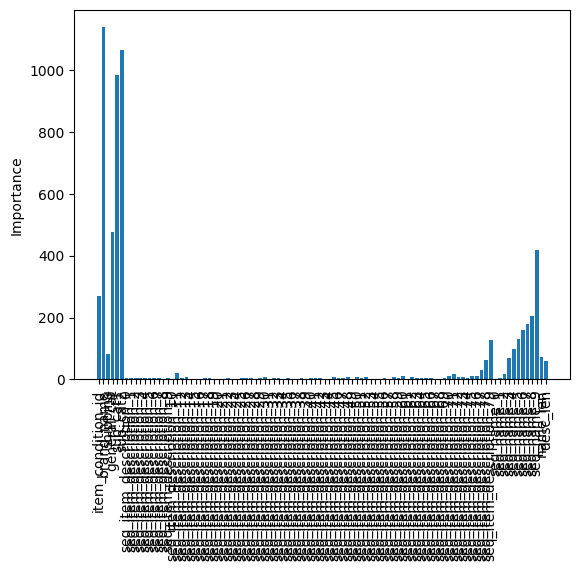

In [43]:
plt.bar(X_train.columns, lgbm.feature_importances_)
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

#### 訓練データに対する予測｜LightGBM

In [44]:
y_train_pred = lgbm.predict(X_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [45]:
y_min = np.append(y_train_pred, y_train).min()
y_max = np.append(y_train_pred, y_train).max()
y_margin = (y_max - y_min) * 0.1
y_min -= y_margin
y_max += y_margin

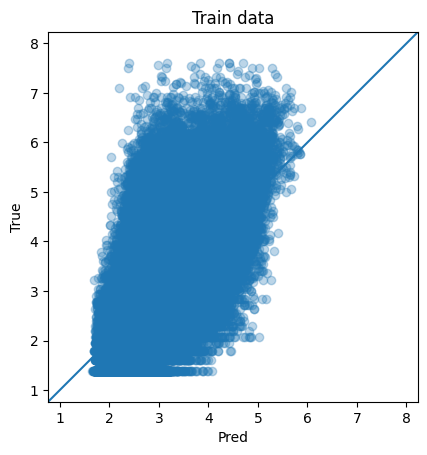

In [46]:
plt.scatter(y_train_pred, y_train, alpha=0.3)
plt.plot([y_min,y_max], [y_min,y_max])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(y_min, y_max)
plt.ylim(y_min, y_max)
plt.title('Train data')
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()

In [47]:
from sklearn.metrics import mean_squared_log_error

# RMSLE関数の定義
def rmsle(y_true, y_pred):  
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [48]:
# モデルの評価
lgb_train_rmsle = rmsle(np.expm1(y_train), np.expm1(y_train_pred))
print("RMSLE for train data:", lgb_train_rmsle)

RMSLE for train data: 0.5577573882691458


#### テストデータに対する予測｜LightGBM

In [49]:
y_test_pred = lgbm.predict(X_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [50]:
y_min = np.append(y_test_pred, y_test).min()
y_max = np.append(y_test_pred, y_test).max()
y_margin = (y_max - y_min) * 0.1
y_min -= y_margin
y_max += y_margin

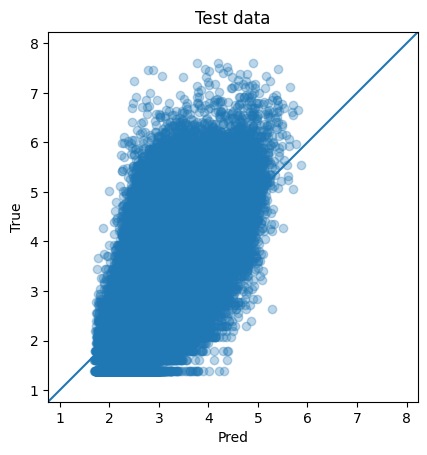

In [51]:
plt.scatter(y_test_pred, y_test, alpha=0.3)
plt.plot([y_min,y_max], [y_min,y_max])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(y_min, y_max)
plt.ylim(y_min, y_max)
plt.title('Test data')
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()

In [52]:
# モデルの評価
lgb_test_rmsle = rmsle(np.expm1(y_test), np.expm1(y_test_pred))
print("RMSLE for test data:", lgb_test_rmsle)

RMSLE for test data: 0.5608032062426322


#### モデルの学習｜RandomForestRegressor

In [53]:
%%time
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0, n_jobs=-1)
rfr.fit(X_train, y_train)

CPU times: user 47min 33s, sys: 450 ms, total: 47min 33s
Wall time: 47min 40s


RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=0)

#### モデルの特徴重要度｜RandomForestRegressor

In [54]:
ser_fi = pd.Series(rfr.feature_importances_, index=X_train.columns)
print(ser_fi.sort_values(ascending=False))

brand_name                 0.226215
sub_cat1                   0.220719
shipping                   0.167668
sub_cat2                   0.136769
general_cat                0.091064
                             ...   
seq_item_description_10    0.000086
seq_item_description_17    0.000074
seq_item_description_1     0.000072
seq_item_description_3     0.000051
seq_name_0                 0.000024
Length: 98, dtype: float64


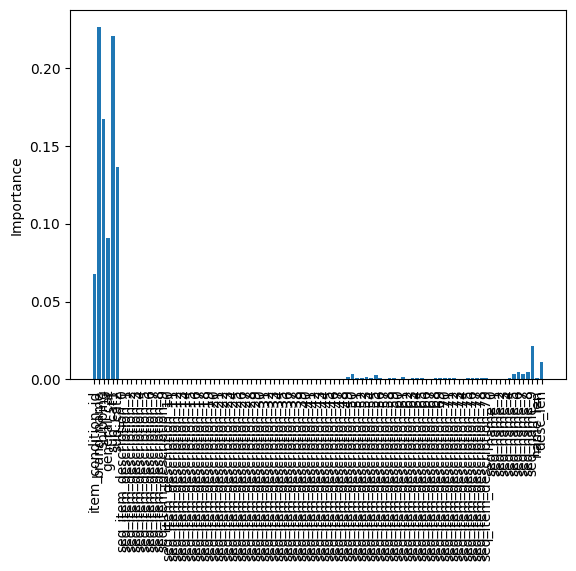

In [55]:
plt.bar(X_train.columns, rfr.feature_importances_)
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

#### 訓練データに対する予測｜RandomForestRegressor

In [56]:
y_train_pred = rfr.predict(X_train)

In [57]:
y_min = np.append(y_train_pred, y_train).min()
y_max = np.append(y_train_pred, y_train).max()
y_margin = (y_max - y_min) * 0.1
y_min -= y_margin
y_max += y_margin

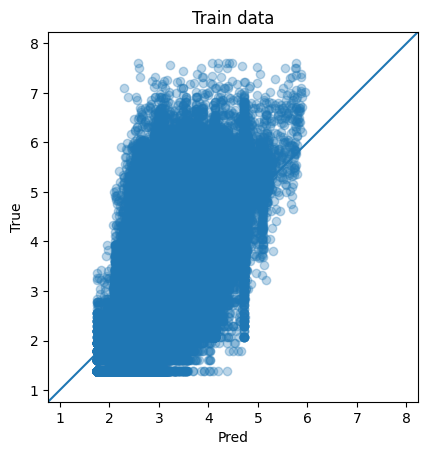

In [58]:
plt.scatter(y_train_pred, y_train, alpha=0.3)
plt.plot([y_min,y_max], [y_min,y_max])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(y_min, y_max)
plt.ylim(y_min, y_max)
plt.title('Train data')
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()

In [59]:
# モデルの評価
rfr_train_rmsle = rmsle(np.expm1(y_train), np.expm1(y_train_pred))
print("RMSLE for train data:", rfr_train_rmsle)

RMSLE for train data: 0.6056543898126008


#### テストデータに対する予測｜RandomForestRegressor

In [60]:
y_test_pred = rfr.predict(X_test)

In [61]:
y_min = np.append(y_test_pred, y_test).min()
y_max = np.append(y_test_pred, y_test).max()
y_margin = (y_max - y_min) * 0.1
y_min -= y_margin
y_max += y_margin

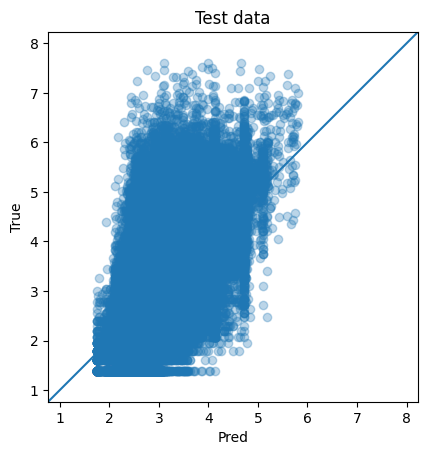

In [62]:
plt.scatter(y_test_pred, y_test, alpha=0.3)
plt.plot([y_min,y_max], [y_min,y_max])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(y_min, y_max)
plt.ylim(y_min, y_max)
plt.title('Test data')
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()

In [63]:
# モデルの評価
rfr_test_rmsle = rmsle(np.expm1(y_test), np.expm1(y_test_pred))
print("RMSLE for test data:", rfr_test_rmsle)

RMSLE for test data: 0.6118253509799623


#### モデルの学習｜Ridge回帰

In [64]:
%%time
from sklearn.linear_model import Ridge

ridge = Ridge(solver="sag", fit_intercept=True, random_state=0, alpha=3)
ridge.fit(X_train, y_train)

CPU times: user 39min 41s, sys: 1.04 s, total: 39min 42s
Wall time: 39min 47s


Ridge(alpha=3, random_state=0, solver='sag')

#### 回帰係数の絶対値｜Ridge回帰

In [65]:
ser_fi = pd.Series(np.abs(ridge.coef_), index=X_train.columns)
print(ser_fi.sort_values(ascending=False))

general_cat                1.503416e-04
desc_len                   1.091535e-04
sub_cat1                   7.555682e-05
brand_name                 6.654385e-05
shipping                   3.614588e-05
                               ...     
seq_item_description_78    4.680181e-08
seq_item_description_3     2.503911e-08
seq_item_description_16    2.227490e-08
seq_item_description_24    9.454930e-09
seq_item_description_74    2.350205e-09
Length: 98, dtype: float64


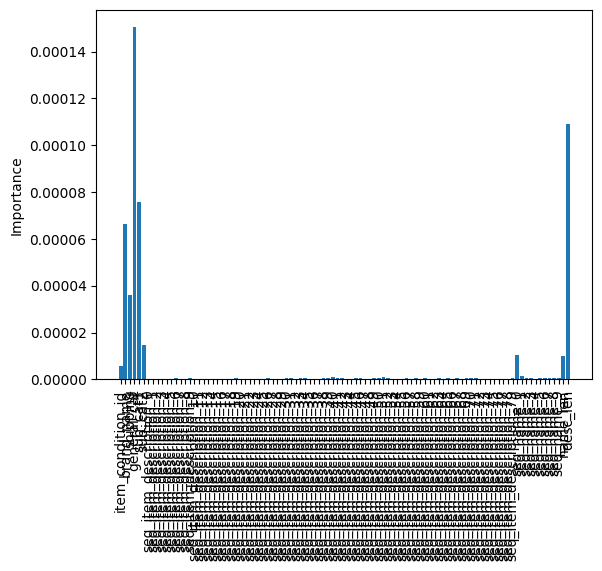

In [66]:
plt.bar(X_train.columns, np.abs(ridge.coef_))
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

#### モデルの特徴重要度｜Ridge回帰
> 変更点  
> **ELI5を用いたRidge回帰モデルの変数重要度の可視化**  
> ELI5はPermutation Importance（置換重要度）を計算する。これは、各特徴量をランダムにシャッフルすることで、その特徴量がモデルの予測に与える影響を評価する。この方法は、単に回帰係数を見るよりも、特徴量の重要度をより正確に評価することができる。  
> また、回帰係数は線形モデルの仮定に基づいて計算されるが、実際のデータには非線形な関係が存在することもある。Permutation Importanceは、モデルの予測性能に基づいて特徴量の重要度を評価するため、非線形な関係も考慮できる。



In [79]:
%%time
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(ridge, random_state=0).fit(X_test, y_test)

CPU times: user 2min 53s, sys: 2min 17s, total: 5min 10s
Wall time: 1min 49s


In [68]:
df_fi = eli5.explain_weights_df(perm, feature_names=X_train.columns.tolist())
print(df_fi.sort_values(by='weight', ascending=False))

                    feature    weight       std
0                brand_name  0.043943  0.000309
1                seq_name_9  0.002352  0.000111
2                seq_name_8  0.000509  0.000069
3                seq_name_7  0.000256  0.000029
4                seq_name_6  0.000218  0.000026
..                      ...       ...       ...
93  seq_item_description_17 -0.000003  0.000003
94  seq_item_description_73 -0.000003  0.000002
95  seq_item_description_15 -0.000006  0.000005
96   seq_item_description_9 -0.000008  0.000014
97  seq_item_description_10 -0.000011  0.000007

[98 rows x 3 columns]


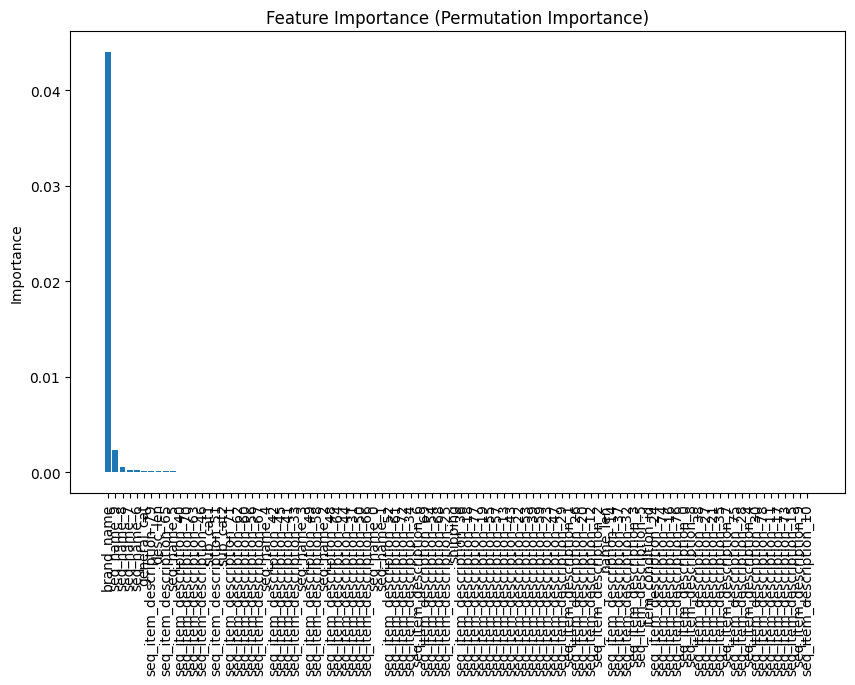

In [69]:
plt.figure(figsize=(10, 6))
plt.bar(df_fi['feature'], df_fi['weight'])
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.title('Feature Importance (Permutation Importance)')
plt.show()

#### 訓練データに対する予測｜Ridge回帰

In [70]:
y_train_pred = ridge.predict(X_train)

In [71]:
y_min = np.append(y_train_pred, y_train).min()
y_max = np.append(y_train_pred, y_train).max()
y_margin = (y_max - y_min) * 0.1
y_min -= y_margin
y_max += y_margin

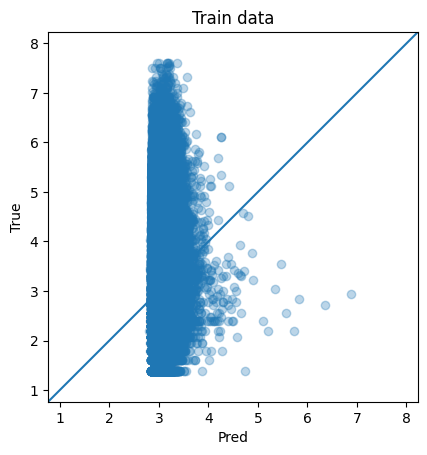

In [72]:
plt.scatter(y_train_pred, y_train, alpha=0.3)
plt.plot([y_min,y_max], [y_min,y_max])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(y_min, y_max)
plt.ylim(y_min, y_max)
plt.title('Train data')
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()

In [73]:
# モデルの評価
ridge_train_rmsle = rmsle(np.expm1(y_train), np.expm1(y_train_pred))
print("RMSLE for train data:", ridge_train_rmsle)

RMSLE for train data: 0.7353347652789024


#### テストデータに対する予測｜Ridge回帰

In [74]:
y_test_pred = ridge.predict(X_test)

In [75]:
y_min = np.append(y_test_pred, y_test).min()
y_max = np.append(y_test_pred, y_test).max()
y_margin = (y_max - y_min) * 0.1
y_min -= y_margin
y_max += y_margin

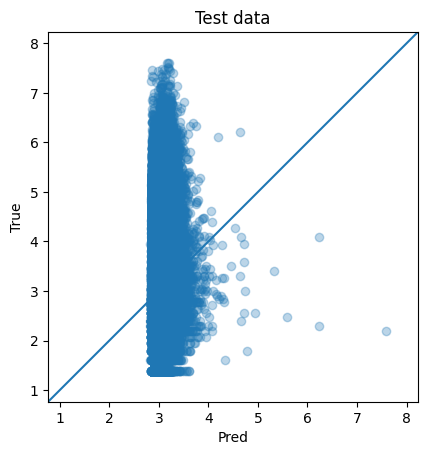

In [76]:
plt.scatter(y_test_pred, y_test, alpha=0.3)
plt.plot([y_min,y_max], [y_min,y_max])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(y_min, y_max)
plt.ylim(y_min, y_max)
plt.title('Test data')
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()

In [77]:
# モデルの評価
ridge_test_rmsle = rmsle(np.expm1(y_test), np.expm1(y_test_pred))
print("RMSLE for test data:", ridge_test_rmsle)

RMSLE for test data: 0.7383223524038255


#### テストデータに対するRMSLEの比較

In [78]:
print(f"lgb_test_rmsle: {lgb_test_rmsle:.3f}")
print(f"rfr_test_rmsle: {rfr_test_rmsle:.3f}")
print(f"ridge_test_rmsle: {ridge_test_rmsle:.3f}")

lgb_test_rmsle: 0.561
rfr_test_rmsle: 0.612
ridge_test_rmsle: 0.738


In [ ]:
stop_real = datetime.now()
execution_time_real = stop_real - start_real
print(execution_time_real)